# Field inference for multiple dipole sources

This notebook demonstrates that it is possible to learn analytical forms like the dipole field with good accuracy with a physically credible network and desirable scaling behaviour. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [2]:
import jax.random as jr
import optax
from hypermagnetics import plots
from hypermagnetics.sources import configure
from hypermagnetics.models.hyper_fourier import FourierModel
from hypermagnetics.runner import fit
import matplotlib.pyplot as plt
import scienceplots  # noqa

plt.style.use(["science", "ieee"])

## I. Target definition and data generation

We expect the neural components of the model to learn transcendental functions. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{2\pi |\mathbf{r}-\mathbf{r_i}|}}^{\text{Surface of 2D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

A realistic (non-pointlike) source will have, in two dimensions, the form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$. 

We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

In [7]:
source_config = {
    "n_samples": 1,
    "lim": 3,
    "res": 64,
}
train = configure(**source_config, n_sources=1, key=jr.PRNGKey(100))
val = configure(**source_config, n_sources=4, key=jr.PRNGKey(101))

In [8]:
model = FourierModel(64, key=jr.PRNGKey(42))
# plots(train, model=model)

In [9]:
schedule = [
    {"optim": optax.adam, "epochs": 10000, "params": {"learning_rate": 1e-2}},
    {"optim": optax.adam, "epochs": 10000, "params": {"learning_rate": 1e-3}},
    {"optim": optax.adam, "epochs": 50000, "params": {"learning_rate": 1e-4}},
    {"optim": optax.adam, "epochs": 50000, "params": {"learning_rate": 1e-5}},
]

for trainer_config in schedule:
    optim = trainer_config["optim"](**trainer_config["params"])
    model = fit(trainer_config, optim, model, train, val, every=100)
    print(model.k)

{'epoch': 0, 'train_loss': 0.013744428753852844, 'train_err': 1226.8968505859375, 'val_err': 1372.6781005859375}
{'epoch': 100, 'train_loss': 0.0018664132803678513, 'train_err': 16.58685874938965, 'val_err': 109.8247299194336}
{'epoch': 200, 'train_loss': 0.0013527870178222656, 'train_err': 12.31987190246582, 'val_err': 110.61502838134766}
{'epoch': 300, 'train_loss': 0.0011170983780175447, 'train_err': 10.356060028076172, 'val_err': 111.22589111328125}
{'epoch': 400, 'train_loss': 0.0009958104928955436, 'train_err': 9.441617965698242, 'val_err': 111.72127532958984}
{'epoch': 500, 'train_loss': 0.0009473899845033884, 'train_err': 9.135238647460938, 'val_err': 112.12141418457031}
{'epoch': 600, 'train_loss': 0.0009279176010750234, 'train_err': 9.026623725891113, 'val_err': 112.38858795166016}
{'epoch': 700, 'train_loss': 0.0009179668850265443, 'train_err': 8.954903602600098, 'val_err': 112.53062438964844}
{'epoch': 800, 'train_loss': 0.000910283240955323, 'train_err': 8.879027366638184,

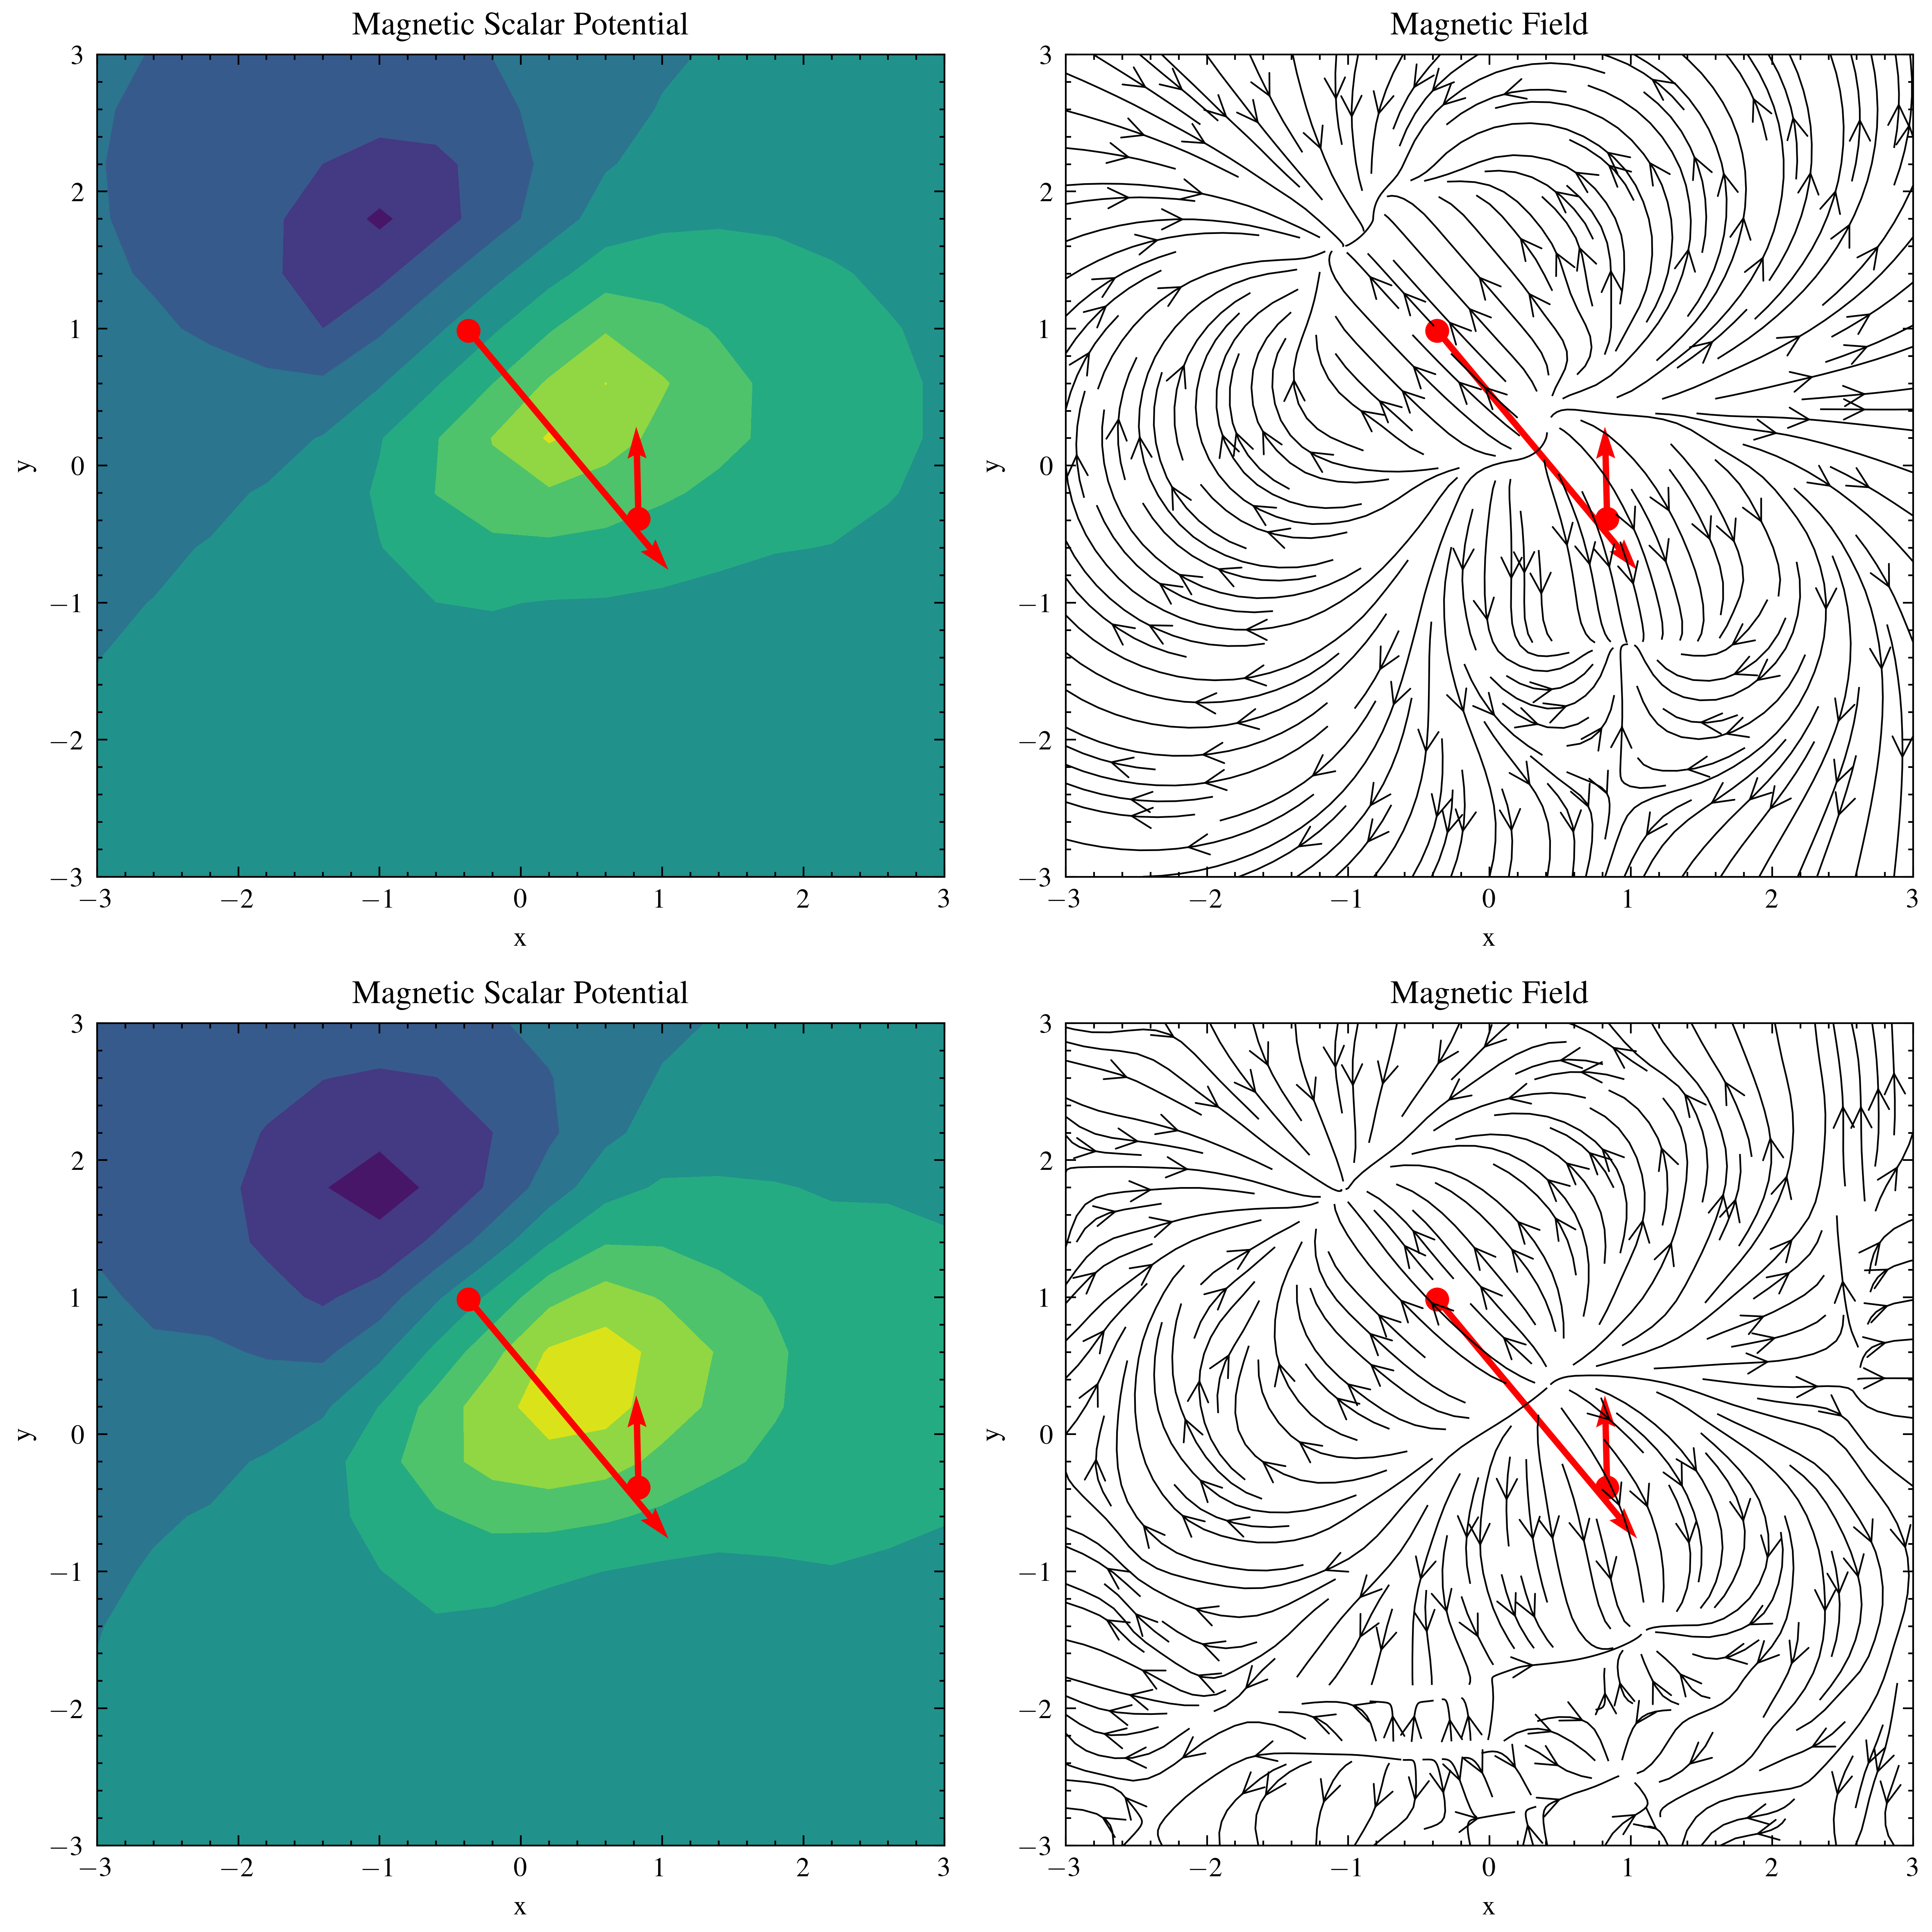

In [10]:
plots(train, model=model)